## 딥러닝 학습
Seq2Seq 선택

+ RNN의 경우 문장이 길어질수록 앞의 정보가 뒤로 충분히 전달되지 못하기 때문에, 최대 길이가 100글자가 넘는 문장을 처리하기에 부적합
+ RNN기반인 LSTM, GRU 또한 이런 장기의존성 문제를 갖고 있음  
    => 인코더-디코더를 이용해 장기의존성 문제를 해결한 Attention 모델 활용  
    => Seq2Seq는 2014년 발표되어 챗봇과 기계번역에 많이 쓰이는 모델로,  
        입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기를 만들 수 있을 것으로 예상

In [1]:
#!pip install jieba
#!pip install keras
#!pip install tensorflow
#!pip install sklearn
#!pip install torch
#!pip install GPUtil
#!pip install numba
#가상환경에 conda install -c anaconda tensorflow-gpu==2.6.0

In [2]:
import pandas as pd
import numpy as np
import glob, os, re, jieba
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Model, save_model, load_model
from keras.layers import Input, LSTM, Dense, Flatten
from keras.callbacks import EarlyStopping

In [3]:
#GPU 사용 가능 여부 확인 => physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability: 8.6" 확인됨
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 528722840093208752
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3663069184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17618985569367405824
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
# tensorflow GPU 사용방법 참고)https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/gpu.ipynb 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU Running')
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        (e)

GPU Running


## 토큰화

In [5]:
def tokenize(language):
    lang_tokenizer = Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(language)
    
    tensor = lang_tokenizer.texts_to_sequences(language)
    tensor = pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [6]:
def preprocess_kr(w):
    w = re.sub(r"([?'!¿\-·\"])", r" \1 ", w)
    w = re.sub(r'[ |ㄱ-ㅎ|ㅏ-ㅣ]+', r" ", w)
    w = re.sub(r"\,(?=[0-9])", r"", w)
    w = w[:-1].strip()
    w = '<start> ' + w + ' <end>'
    return w  

def preprocess_ch(w):
    w = ' '.join(jieba.cut(w, cut_all=False))   
    w = w[:-1].rstrip().strip()   
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
#1_preprocessing.ipynb에서 만들었던 함수 활용(용량 문제 해결 위해 num_data 파라미터 추가)
def tokenize_dataset(path, num_data):
    files = glob.glob(os.path.join(path, '*.csv'))
    ch, ko = [], []
    
    for f in files:
        df = pd.read_csv(f)
        ch.extend(df['중국어'].values)
        ko.extend(df['한국어'].values)
    
    ch_series = pd.Series(ch)
    ko_series = pd.Series(ko)
    
    df = pd.concat([ch_series, ko_series], axis=1)
    df.columns = ['중국어', '한국어']
    
    df['중국어'] = df['중국어'].apply(preprocess_ch)
    df['한국어'] = df['한국어'].apply(preprocess_kr)
    
    df = df.sample(num_data, random_state=2)
    
    ch_tensor, ch_tokenizer = tokenize(df['중국어'].values)
    ko_tensor, ko_tokenizer = tokenize(df['한국어'].values)
    
    return ch_tensor, ko_tensor, ch_tokenizer, ko_tokenizer

In [8]:
#num_data만큼 데이터셋 크기를 제한
num_data = 1000   #이 이상이면 OOM error 발생...

path = os.getcwd() + '\\Training'
ch_tensor, ko_tensor, ch_lang, ko_lang = tokenize_dataset(path, num_data)   #약 5분 소요

#입력 텐서, 타겟 텐서의 최대 길이 계산
max_length_ch = ch_tensor.shape[1]
max_length_ko = ko_tensor.shape[1]
print('중국어 tensor 최장 길이 : {}'.format(max_length_ch))
print('한국어 tensor 최장 길이 : {}'.format(max_length_ko))

C:\Users\yeonok\AppData\Local\Temp/ipykernel_15336/977542252.py:5: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  ch_tensor, ko_tensor, ch_lang, ko_lang = tokenize_dataset(path, num_data)   #약 5분 소요
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yeonok\AppData\Local\Temp\jieba.cache
Loading model cost 0.446 seconds.
Prefix dict has been built successfully.


In [ ]:
ch_tensor_train, ch_tensor_val, ko_tensor_train, ko_tensor_val = train_test_split(ch_tensor, ko_tensor, test_size=0.2)

print('훈련 데이터셋 크기 : {}, {}'.format(len(ch_tensor_train), len(ko_tensor_train)))
print('검증 데이터셋 크기 : {}, {}'.format(len(ch_tensor_val), len(ko_tensor_val)))

훈련 데이터셋 크기 : 800, 800
검증 데이터셋 크기 : 200, 200


In [ ]:
def convert(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print("%12d ----> %s" % (t, tokenizer.index_word[t]))  
            
print('중국어 index ----> token')
convert(ch_lang, ch_tensor_train[0])
print()
print('한국어 index ----> token')
convert(ko_lang, ko_tensor_train[0])

중국어 index ----> token
           3 ----> <start>
        1316 ----> 旗下
         276 ----> 包括
         197 ----> 社会
        1385 ----> 康复
         853 ----> 组
           7 ----> 、
        3421 ----> 后援
         212 ----> 开发
         853 ----> 组
           7 ----> 、
         248 ----> 生活
        1385 ----> 康复
         853 ----> 组
           7 ----> 、
         527 ----> 医疗
        1385 ----> 康复
         853 ----> 组
           7 ----> 、
        1193 ----> 会计
         120 ----> 管理
        3422 ----> 组和
        3423 ----> 炊事
        3424 ----> 洗涤
         853 ----> 组
           2 ----> ,
        1386 ----> 共有
         938 ----> 31
         105 ----> 名
         316 ----> 职员
           4 ----> <end>

한국어 index ----> token
           1 ----> <start>
        3628 ----> 산하에
        3629 ----> 사회재활팀,
        3630 ----> 후원개발팀,
        3631 ----> 생활재활팀,
        3632 ----> 의료재활팀,
        3633 ----> 회계관리팀,
        3634 ----> 취사세탁팀이
         312 ----> 있으며,
         146 ----> 총
        3635 ----> 31명의
 

### tf.data 데이터셋 생성하기

In [ ]:
BUFFER_SIZE = len(ch_tensor_train)
BATCH_SIZE = 4   #Out of Memory 에러 주의...ㅠ
steps_per_epoch = len(ch_tensor_train) // BATCH_SIZE
embedding_size = 256
units = 1024

vocab_input_size = len(ch_lang.word_index) + 1  
vocab_target_size = len(ko_lang.word_index) + 1 

print('중국어 토큰 개수 : {}'.format(vocab_input_size))
print('한국어 토큰 개수 : {}'.format(vocab_target_size))

중국어 토큰 개수 : 6623
한국어 토큰 개수 : 10686


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((ch_tensor_train, ko_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))

print(example_input_batch.shape, example_target_batch.shape)

(1, 83) (1, 41)


### 인코더 모델 생성
+ Attention을 가진 인코더-디코더 모델을 생성
+ input(중국어) => [batch_size, max_length_input, hidden_size]
+ 임베딩 층(hidden state) => [batch_size, max_length_input, embedding_dim]
+ GRU(Gated Recurrent Unit, 게이트 순환 유닛) 층 => output(한국어)[batch_size, max_length_input, enc_units],  
                히든레이어[batch_size, enc_units]

> 슈도코드 (FC=완전연결(Dense)층, EO=인코더 결과, H=은닉상태(hidden state), X=디코더에 대한 입력)

+ score = FC(tanh(FC(EO) + FC(H)))로 계산하며, 형태는 [batch_size, max_length_input, hidden_size]
+ 어텐션 가중치는 softmax(score, axis=1) 
+ 컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)
+ 임베딩 결과(embedding output)는 디코더 X에 대한 입력이 임베딩층을 통과한 결과
+ 병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))와 같음
+ 그런 다음 병합된 벡터는 GRU에 주어짐

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))


In [ ]:
encoder = Encoder(vocab_input_size, embedding_size, units, BATCH_SIZE)

#샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print(f'Encoder output (batch size, sequence length, units) = {sample_output.shape}')   
print(f'Encoder Hidden state  (batch size, units) = {sample_hidden.shape}')            

Encoder output (batch size, sequence length, units) = (1, 83, 1024)
Encoder Hidden state  (batch size, units) = (1, 1024)


### Attention 매커니즘
+ output [batch_size, max_length_inp, enc_units] => values 로 사용
+ 히든레이어 [batch_size, enc_units] => query 로 사용
+ (참고)https://hcnoh.github.io/2018-12-11-bahdanau-attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        #query hidden state는 (batch_size, hidden_size)로 구성
        #query_with_time_axis는 (batch_size, 1, hidden_size)로 구성
        #values는 (batch_size, max_len, hidden_size)로 구성
        query_with_time_axis = tf.expand_dims(query, 1)

        #score는 (batch_size, max_len, units)로 구성
        #score를 self.V에 적용하기 때문에 마지막 축에 1을 얻어 (batch_size, max_len, 1)로 구성되게 됨
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))

        #attention_weights는 (batch_size, max_len, 1)로 구성
        attention_weights = tf.nn.softmax(score, axis=1)

        #병합 이후 context_vector는 (batch_size, hidden_size)로 구성
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f"Attention result shape: (batch size, units) {attention_result.shape}")
print(f"Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}")

Attention result shape: (batch size, units) (1, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (1, 83, 1)


### 디코더 모델 생성

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):    # 단어 하나하나 해석 진행 
        #            hidden (batch_size, units),    enc_output (batch_size, max_length_inp, enc_units)
        # =>context_vector (batch_size, enc_units), attention_weights (batch_size, max_length_inp, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 임베딩 층 통과 후 x는 (batch_size, 1, embedding_dim)로 구성
        x = self.embedding(x)
        
        #context vector과 임베딩 결과를 결합한 후 x는 (batch_size, 1, embedding_dim+hidden_size)로 구성
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        #위에서 결합된 벡터를 GRU에 전달
        output, state = self.gru(x)
        
        #output은 (batch_size*1, hidden_size)로 구성
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #FC(완전연결층)을 지난 x는 (batch_size, vocab)으로 구성
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_target_size, embedding_size, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (1, 10686)


### optimizer(최적화함수), 손실함수 정의

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_objects = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                             reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_objects(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 모델 훈련
1. 인코더 결과와 인코더 은닉 상태(hidden state)를 반환하는 인코더를 통해서 입력을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (start 토큰)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 예측 값과 디코더 은닉 상태(hidden state)를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 교사 강요(teacher forcing)를 사용합니다.
6. 교사 강요(teacher forcing)는 타겟 단어가 디코더에 다음 입력으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [ ]:
#체크포인트(객체 기반 저장)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cpkt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, 
                                 encoder=encoder,
                                 decoder=decoder)

manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir,
                                     checkpoint_name='model.ckpt',
                                     max_to_keep=3)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([ko_lang.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            #enc_output을 디코더에 전달
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                                 enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)    #teacher forcing(다음 input으로 target을 feeding)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, variables))
    
    return batch_loss

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:4f}".format(epoch+1, batch, batch_loss.numpy()))

    print('Epoch {} Loss {:.4f}'.format(epoch+1, total_loss/steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time()-start))
        
    checkpoint.save(file_prefix=checkpoint_prefix)
    manager.save()    

Epoch 1 Batch 0 Loss 2.262767
Epoch 1 Batch 100 Loss 5.591594
Epoch 1 Batch 200 Loss 3.698721
Epoch 1 Batch 300 Loss 2.917143
Epoch 1 Batch 400 Loss 3.544982
Epoch 1 Batch 500 Loss 2.745366
Epoch 1 Batch 600 Loss 4.207155
Epoch 1 Batch 700 Loss 4.675448
Epoch 1 Loss 3.9450
Time taken for 1 epoch 163.29538822174072 sec

Epoch 2 Batch 0 Loss 3.497820
Epoch 2 Batch 100 Loss 1.604756
Epoch 2 Batch 200 Loss 6.129208
Epoch 2 Batch 300 Loss 2.456604
Epoch 2 Batch 400 Loss 6.330091
Epoch 2 Batch 500 Loss 3.688547
Epoch 2 Batch 600 Loss 4.515466
Epoch 2 Batch 700 Loss 4.311893
Epoch 2 Loss 3.6094
Time taken for 1 epoch 130.67000007629395 sec

Epoch 3 Batch 0 Loss 3.739125
Epoch 3 Batch 100 Loss 4.039585
Epoch 3 Batch 200 Loss 1.763470
Epoch 3 Batch 300 Loss 3.101741
Epoch 3 Batch 400 Loss 3.738113
Epoch 3 Batch 500 Loss 2.375816
Epoch 3 Batch 600 Loss 1.780170
Epoch 3 Batch 700 Loss 2.710972
Epoch 3 Loss 3.4383
Time taken for 1 epoch 131.4684956073761 sec

Epoch 4 Batch 0 Loss 2.536519
Epoch 4 

### 훈련된 모델을 사용해 번역해보기
+ 각 마지막 시점에서 이전 디코더에서의 인코더 결과(하나의 입력에 대해 단 한번만 계산됨)와 hidden state를 가진 예측값을 디코더에 입력
+ 모델이 \<end\> 토큰을 예측하는 순간 예측 중지
+ 마지막 시점마다 attention 가중치 저장

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_ko, max_length_ch))

    sentence = preprocess_ch(sentence)
    
    inputs = [ch_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_ch, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([ko_lang.word_index['<start>']], 0)
    
    for t in range(max_length_ko):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input, dec_hidden, enc_out)
        
        #나중에 attention 가중치를 시각화하기 위해 저장해두기
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += ko_lang.index_word[predicted_id] + ' '

        if ko_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        #예측된 id를 모델에 다시 feeding
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
#attention 가중치 그리는 함수
def plot_attention(attention, sentence, predicted_sentence):
    from matplotlib import font_manager, rc  #한국어, 중국어 폰트 깨짐 해결
    font_path = "C:/Users/yeonok/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 16}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show();

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print("Input : %s" % (sentence))
    print("Translation : {}".format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
#checkpoint_dir내에 있는 최근 체크포인트 복원
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
val_df = pd.read_csv('val_df.csv', index_col=0)
val_sample = val_df.sample(10, random_state=2)
val_sample

,중국어,한국어
121833,"大多数大学只将开课时间推迟两周,其余两周的教务日程则改为网上授课。","대다수 대학들은 개강을 2주만 연기하고, 나머지 2주 학사 일정은 온라인 강의로 대..."
108103,"亚马逊为了集中于电子商务而暂时错失了订阅经济的大势,开始了名为""Amazon Prime V...",전자상거래에 집중하느라 구독경제의 대세를 잠시 놓친 아마존은 아마존 프라임 비디오라...
141210,"以""偶像一视界""(Idol One-Top Visual)的修饰语俘获众多女性芳心的Jell...",'아이돌 원톱 비주얼'이란 수식어로 많은 여성들의 마음을 훔친 젤리피쉬 김민규가 신...
94037,"上月25日,百货商店业界首次举行了没有观众在线直播的""2020数字直播时装秀""",지난달 25일에는 백화점 업계 최초로 관중 없이 온라인으로 생중계되는 '2020 디...
214275,"因此,在转换成线性模式后转为切换模式时,可以有效防止瞬时浪涌电流的出现,并且可以实现稳定的模...","이에 따라, 리니어 모드 후 스위칭 모드로 전환될 때 나타나는 순간적인 돌입전류의 ..."
118000,国内网络大学首次开设的声乐系将提供1对1在线授课、1对1辅导、1对3辅导、大师班针对学生的专...,"국내 사이버대 최초로 개설된 성악과는 1대1 온라인강의, 1대1 레슨, 1대3 레슨..."
100308,"该课程的目标是培养能够使企业稳定、有效地进行系统管理的云系统开发程序员,即,培养以AWS(现...",해당 과정은 기업시스템을 안정적이고 효율적으로 관리할 수 있도록 클라우드 시스템을 ...
208689,"本发明既可以抑制被处理基板的意外氧化,又可以抑制被处理基板的一面和另一方加热的不均匀。",본 발명은 피처리 기판의 의도하지 않는 산화를 억제하는 것과 함께 피처리 기판의 일...
32837,"为了开放、利用学校设施,建立终身学习社会基础,以家长和地区居民为对象,事先调查了他们所希望听...",학교시설을 개방·활용하여 평생학습 사회 기반을 조성하고자 학부모와 지역주민을 대상으...
123569,这也是新手Youtuber们容易挑战的VLOG的常客路线。,초보 유튜버들이 도전하기 쉬운 브이로그 단골 코스이기도 하다.


Input : <start> 大多数 大学 只 将 开课时间 推迟 两周 , 其余 两周 的 教务 日程 则 改为 网上 授课 <end>
Translation : 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 


C:\Users\yeonok\AppData\Local\Temp/ipykernel_1560/92293786.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
C:\Users\yeonok\AppData\Local\Temp/ipykernel_1560/92293786.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23558 (\N{CJK UNIFIED IDEOGRAPH-5C06}) 

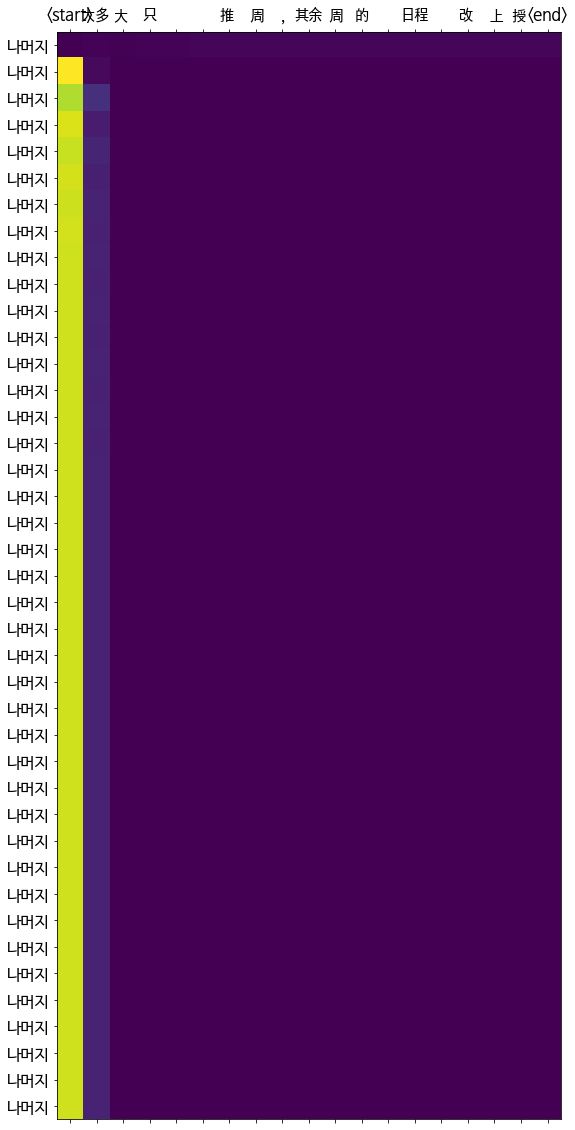

Intended Output : 대다수 대학들은 개강을 2주만 연기하고, 나머지 2주 학사 일정은 온라인 강의로 대체했다.
亚马逊为了集中于电子商务而暂时错失了订阅经济的大势,开始了名为"Amazon Prime Video"的订阅服务,与相差9倍多的Netflix的距离现在缩小到了2.8倍。 => 데이터셋에 없는 단어 포함
以"偶像一视界"(Idol One-Top Visual)的修饰语俘获众多女性芳心的Jellyfish金旻奎将作为新的美容综艺Beauty Trend Show(Pink Festa)的主持人的参与。 => 데이터셋에 없는 단어 포함
Input : <start> 上 月 25 日 , 百货商店 业界 首次 举行 了 没有 观众 在线 直播 的 " 2020 数字 直播 时装秀 <end>
Translation : 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 


c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36135 (\N{CJK UNIFIED IDEOGRAPH-8D27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20030 (\N{CJK UNIFIED IDEOGRAPH-4E3E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27809 (\N{CJK UNIFIED IDEOGRAPH-6CA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 352

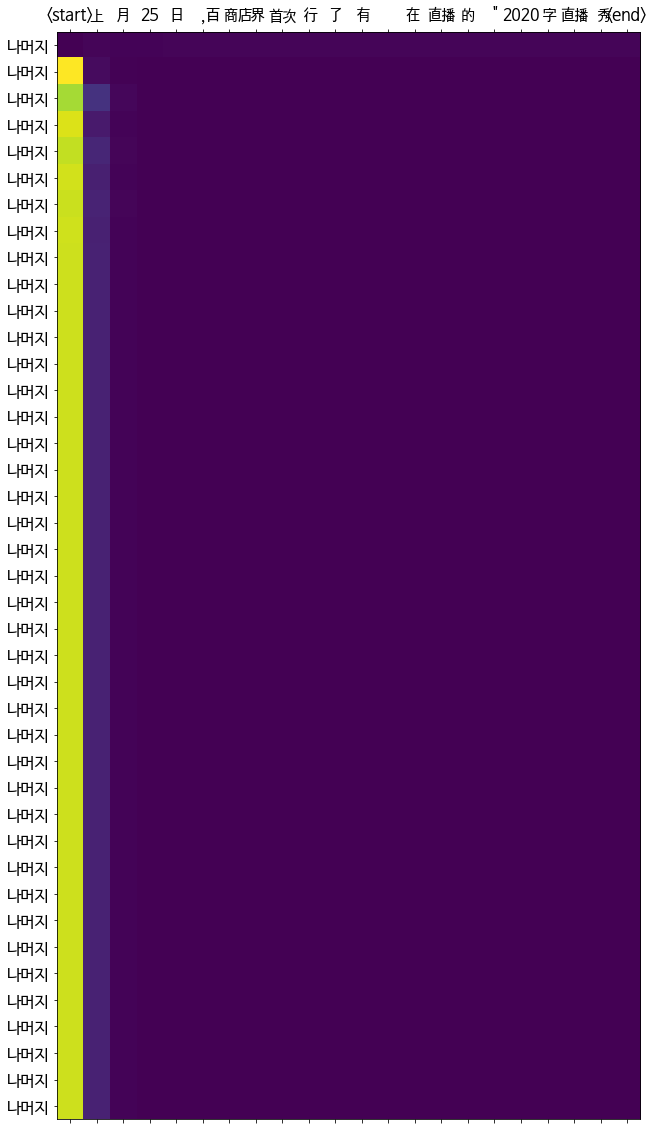

Intended Output : 지난달 25일에는 백화점 업계 최초로 관중 없이 온라인으로 생중계되는 '2020 디지털 라이브 패션쇼'를 열었다.
Input : <start> 因此 , 在 转换成 线性 模式 后 转为 切换 模式 时 , 可以 有效 防止 瞬时 浪涌 电流 的 出现 , 并且 可以 实现 稳定 的 模式 切换 <end>
Translation : 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 나머지 


c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29616 (\N{CJK UNIFIED IDEOGRAPH-73B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 241

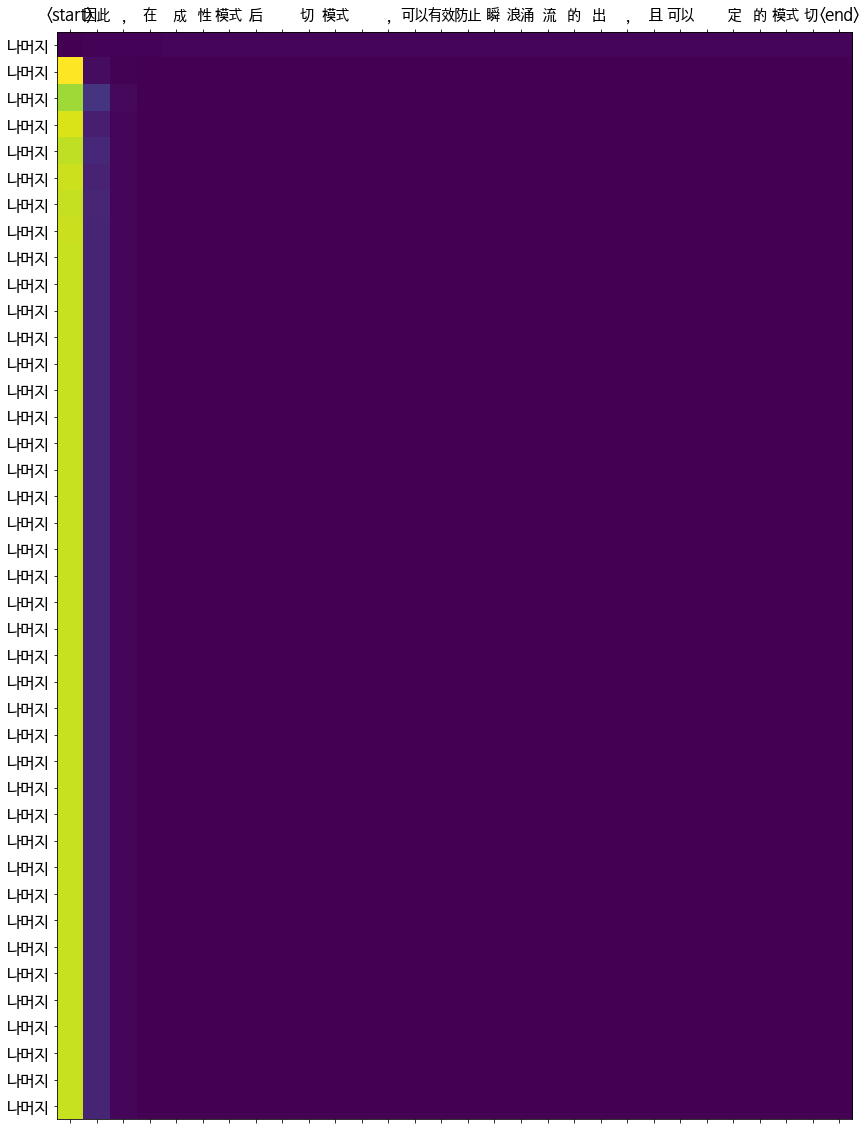

Intended Output : 이에 따라, 리니어 모드 후 스위칭 모드로 전환될 때 나타나는 순간적인 돌입전류의 발생을 효과적으로 방지할 수 있고 안정된 모드 전환이 이루어질 수 있게 된다.
国内网络大学首次开设的声乐系将提供1对1在线授课、1对1辅导、1对3辅导、大师班针对学生的专业技能教育。 => 데이터셋에 없는 단어 포함
该课程的目标是培养能够使企业稳定、有效地进行系统管理的云系统开发程序员,即,培养以AWS(现行工作空间)为基础的数据专家、企业网络、云计算、以及能够充分体现存储能力的专家。 => 데이터셋에 없는 단어 포함
本发明既可以抑制被处理基板的意外氧化,又可以抑制被处理基板的一面和另一方加热的不均匀。 => 데이터셋에 없는 단어 포함
为了开放、利用学校设施,建立终身学习社会基础,以家长和地区居民为对象,事先调查了他们所希望听的讲座。 => 데이터셋에 없는 단어 포함
这也是新手Youtuber们容易挑战的VLOG的常客路线。 => 데이터셋에 없는 단어 포함


In [ ]:
for idx, i in enumerate(val_sample['중국어'].values):
    try:
        translate(u'{}'.format(i))
        print("Intended Output : %s" % (val_sample.iloc[idx,1]))
    except:
        print(i, '=> 데이터셋에 없는 단어 포함')

+ 훈련 데이터 양이 너무 적어서 그런지 예상이 형편없음...
+ 그래서 훈련되지 않은 단어가 입력되면 아예 에러가 나기도 함

### 아래는 조금 다르게 작성해본 코드

In [ ]:
def tokenize(train_df):
    #글자단위 토큰화
    ch_vocab, ko_vocab = set(), set()

    for line in train_df['중국어']:
        for c in line:
            ch_vocab.add(c)

    for line in train_df['한국어']:
        for c in line:
            ko_vocab.add(c)
            
    ch_vocab_size = len(ch_vocab) + 1  #94
    ko_vocab_size = len(ko_vocab) + 1  #4837
    
    #set -> list(데이터 변경 용이한 자료구조로 변환)
    ch_vocab = sorted(list(ch_vocab))
    ko_vocab = sorted(list(ko_vocab))
    
    ch_to_index = dict([(c, i+1) for i, c in enumerate(ch_vocab)])
    ko_to_index = dict([(c, i+1) for i, c in enumerate(ko_vocab)])
    
    #중국어 문장 인코딩
    encoder_input = []
    for li in train_df['중국어']:
        t = []
        for c in li:
            t.append(ch_to_index[c])
        encoder_input.append(t)
        
    #한국어 문장 인코딩
    decoder_input = []
    for li in train_df['한국어']:
        t = []
        for c in li:
            t.append(ko_to_index[c])
        decoder_input.append(t)   
        
    #번역되어 나올 한국어 문장 인코딩에서 '\t' 제거
    decoder_ko = []
    for li in train_df['한국어']:
        t = []
        i = 0
        for c in li:
            if i > 0:
                t.append(ko_to_index[c])
            i += 1
        decoder_ko.append(t)    
     
    #패딩
    max_len_ch = 1689
    max_len_ko = 373
    
    #문장 -> int -> padding
    encoder_input = pad_sequences(encoder_input, maxlen=max_len_ch, padding='post')
    decoder_input = pad_sequences(decoder_input, maxlen=max_len_ko, padding='post')
    decoder_ko = pad_sequences(decoder_ko, maxlen=max_len_ko, padding='post') 
    
    #문장들을 3차원 배열로 변환 : (encoder_input, decoder_input, decoder_target)
    #encoder_input은 (문장 개수, 문장 최대 길이, 문자 종류 수) 형태의 3차원 배열로 중국어 문장의 one-hot 형식 벡터 데이터
    #decoder_input은 (문장 개수, 문장 최대 길이, 문자 종류 수) 형태의 3차원 배열로 한국어 문장의 one-hot 형식 벡터 데이터
    #decoder_ko은 decoder_input과 같지만, 하나의 time step만큼 offset, 즉, decoder_target[:, t, :] = decoder_input[:, t+1, :]
    encoder_input = np_utils.to_categorical(encoder_input)
    decoder_input = np_utils.to_categorical(decoder_input)
    decoder_ko = np_utils.to_categorical(decoder_ko)
    
    return encoder_input, decoder_input, decoder_ko, ch_vocab_size, ko_vocab_size, index_to_ch, index_to_ko

#### 데이터가 너무 많으면 한번에 토큰화할 수 없기 때문에,
#### 데이터를 4000개씩 나누어 토큰화 > 모델학습 > 저장 > 전이학습 반복

In [ ]:
df = train_df[:4000]
    
encoder_input, decoder_input, decoder_ko, ch_vocab_size, ko_vocab_size, index_to_ch, index_to_ko = tokenize(df)

#중국어 인코딩
tmp_dict = dict((i,c ) for c , i in index_to_ch.items()) 

for i in tmp_dict:
    try:
        tmp_dict[i] = tmp_dict[i].encode('EUC_CN')
    except:
        pass
    
index_to_ch = dict((i,c ) for c , i in tmp_dict.items()) 

NameError: name 'train_df' is not defined

In [ ]:
# 트레이닝 시 이전 상태의 실제값을 현재상태의 디코더 입력으로 해야함(예측값으로 하면 안됨)
encoder_inputs = Input(shape=(None, ch_vocab_size), name='encoder_input')
decoder_inputs = Input(shape=(None, ko_vocab_size ), name='decoder_input')

# 인코더 LSTM 셀
encoderLSTM = LSTM(units=256, return_state=True, name='encoderLSTM')    #return_state :인코더의 마지막 상태 정보를 디코더의 입력 상태 정보로 전달
decoderLSTM = LSTM(units=256, return_sequences=True, return_state=True, name='decoderLSTM')

# 인코더 LSTM셀의 입력 정의
encoder_outputs, stateH, stateC = encoderLSTM(encoder_inputs) # _, 히든상태(위), 셀상태(오른쪽)
encoder_state = [stateH, stateC] # 컨텍스트 벡터

decoder_output, _, _ = decoderLSTM(decoder_inputs, initial_state=encoder_state)
decoder_softmax = Dense(ko_vocab_size, activation="softmax")
decoder_output = decoder_softmax(decoder_output)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_output)

model.summary()

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x=[encoder_input,decoder_input], y=decoder_ko, batch_size=64, epochs=50, callbacks=early_stopping)
save_model(model, 'ch_to_ko.h5', overwrite=True)

In [ ]:
for i in range(1,len(train_df) // 2500):
    df = train_df[i*(2500):(i+1)*2500]
    
    encoder_input, decoder_input, decoder_ko, ch_vocab_size, ko_vocab_size = tokenize(df)

    model = load_model('ch_to_ko.h5')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(x=[encoder_input, decoder_input], y=decoder_ko, batch_size=64, epochs=3, callbacks=early_stopping)
    save_model(model, 'ch_to_ko.h5', overwrite=True)

In [ ]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_state)

ch_to_index = dict((i,c ) for c , i in index_to_ch.items()) 
ko_to_index = dict((i,c ) for c , i in index_to_ko.items()) 

In [ ]:
encoder_model.summary()

In [ ]:
# 디코더
decoder_state_input_hidden = Input(shape=(256,))
decoder_state_input_cell = Input(shape=(256,))
decoder_state_input = [decoder_state_input_hidden, decoder_state_input_cell]

decoder_output, state_hidden, state_cell = decoderLSTM(decoder_inputs, initial_state = decoder_state_input)
decoder_state = [state_hidden, state_cell]
decoder_outputs = decoder_softmax(decoder_output)

decoder_model = Model(inputs=[decoder_inputs]+decoder_state_input, outputs=[decoder_output]+decoder_state)

In [ ]:
decoder_model.summary()

In [ ]:
def decode_seq(input_seq): 
    
    state_value = encoder_model.predict(input_seq)
    print('encoder_model의 예상 state_value :',np.shape(state_value))
    
    target_seq = np.zeros((1,1,ko_vocab_size))   #(1, 1, 1134)
    target_seq[0,0,ko_to_index['\t']] = 1      # 원핫인코딩
    
    stop = False
    decoded_sent=""
    while not stop: # "\n"문자를 만날때까지 반복
        
        output, h, c = decoder_model.predict([target_seq]+state_value)
        # 예측값을 한국어 문자로 변환
        token_index = np.argmax(output[0,-1,:]) 
        pred_char = index_to_ko[token_index]
        
        # 현시점 예측문자가 예측문장에 추가
        decoded_sent += pred_char
        
        if (pred_char == "\n" or len(decoded_sent) > 373):
            stop = True
            
        # 현시점 예측결과가 다음 시점에 입력으로 
        target_seq = np.zeros((1,1,ko_vocab_size))
        target_seq[0,0,token_index] = 1
        
        # 현시점 상태를 다음 시점 상태로 사용
        state_value = [h,c]
    
    return decoded_sent # 번역결과

In [ ]:
for seq_index in [1,50,100,200,300]:
    
    input_seq = encoder_input[seq_index:seq_index+1]    # (1, 117, 2326)
    decoded_seq = decode_seq(input_seq)
    
    print("입력문장:", train_df['중국어'][seq_index])
    print("정답:", train_df['한국어'][seq_index][1:len(train_df['한국어'][seq_index])-1])   # "\t", "\n" 제거
    print("번역기:", decoded_seq[:len(decoded_seq)-1])
    print("\n")

## 모델이 잘 작동하는지 확인하기 위해 일부 문장 디코딩
    -encoder_input을 샘플링해 decoder_target으로 변환해본다.